In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

labels = ['no' , "sphere" , "vort"]


train_folder = "dataset/train"
val_folder = "dataset/val"  


In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


def multiclass_auc_score(y_true, y_pred):
    n_classes = y_true.shape[1]
    auc_values = []
    for i in range(n_classes):
        auc_values.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
    return np.mean(auc_values)

In [2]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, mode='train', transform=None):
        self.mode = mode
        self.transform = transform
        self.data = []
        self.labels = []
        self.class_names = {0: "no", 1: "sphere", 2: "vort"}

        if self.mode == 'train':
            self.load_data("dataset//train//no//", 0)
            self.load_data("dataset//train//sphere//", 1)
            self.load_data("dataset//train//vort//", 2)
        elif self.mode == 'test':
            self.load_data("dataset//val//no//", 0)
            self.load_data("dataset//val//sphere//", 1)
            self.load_data("dataset//val//vort//", 2)

    def load_data(self, directory, label):
        files = os.listdir(directory)
        for file in files:
            image = np.load(os.path.join(directory, file)).astype(np.float32)
            image = np.reshape(image, (image.shape[1], image.shape[2], 1))
            self.data.append(image)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label




transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([transforms.CenterCrop(100)], p=0.40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation([-90,90]),
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])


test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])



train_dataset = CustomDataset(mode='train', transform=transform)
test_dataset = CustomDataset(mode='test', transform=test_transform)

In [3]:
print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))

print(train_dataset[0][0].shape)

Train dataset size:  30000
Test dataset size:  7500
torch.Size([1, 224, 224])


In [4]:
from alive_progress import alive_bar



def train (epochs , batch_size , train_set , test_set , model , optimizer , lr_scheduler , criterion , model_name ):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    #LOAD BEST MODEL
    if os.path.exists(f'{model_name}.pth'):
        model.load_state_dict(torch.load(f'{model_name}.pth'))

    best_acc = 0.0
    best_auc = 0.0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        with alive_bar(len(train_loader) , force_tty=True) as bar:
            for i, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device)
                images = images.float()
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_accuracy += (preds == labels).sum().item()
                #reduce learning rate on plateau
                #scheduler.step(train_loss)
                # lr_scheduler.step()
                bar()
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss / len(train_loader.dataset):.4f}, Train Accuracy: {train_accuracy / len(train_loader.dataset) * 100:.2f}%')
        
        model.eval()
        test_loss = 0.0
        test_accuracy = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():
            with alive_bar(len(test_loader) , force_tty=True) as bar:
                for i, (images, labels) in enumerate(test_loader):
                    images = images.to(device)
                    labels = labels.to(device)
                    images = images.float()
                    # Forward pass
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    test_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    test_accuracy += (preds == labels).sum().item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    bar()

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        #ravel y_pred
        y_pred = y_pred.ravel()
        #one hot encoding with np.eye
        y_true_one_hot = np.eye(3)[y_true]
        y_pred_one_hot = np.eye(3)[y_pred]
        # Calculate ROC AUC score
        auc = multiclass_auc_score(y_true_one_hot, y_pred_one_hot)
        print(f'Epoch [{epoch + 1}/{epochs}], Test Loss: {test_loss / len(test_loader.dataset):.4f}, Test Accuracy: {test_accuracy / len(test_loader.dataset) * 100:.2f}%, AUC: {auc:.4f}')
        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), f'{model_name}.pth')

In [ ]:
#Resnet 18

import timm
from torch.optim import Adam,AdamW
from torch import nn
import torch

model = timm.create_model('resnet18', pretrained=True , num_classes=3 , in_chans=1) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters() , 0.0001)
EPOCHS = 200

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

train(EPOCHS , 16 , train_dataset , test_dataset , model , optimizer , scheduler , criterion , "ResNet18")

superresolution-lensing

/home/arnesh/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_40846/4102255395.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_on

|████████████████████████████████████████| 1875/1875 [100%] in 1:16.5 (24.51/s) 
Epoch [1/200], Train Loss: 0.0650, Train Accuracy: 43.71%
|████████████████████████████████████████| 469/469 [100%] in 6.4s (73.50/s)     
Epoch [1/200], Test Loss: 0.0601, Test Accuracy: 51.13%, AUC: 0.6335
|████████████████████████████████████████| 1875/1875 [100%] in 1:16.1 (24.62/s) 
Epoch [2/200], Train Loss: 0.0567, Train Accuracy: 55.38%
|████████████████████████████████████████| 469/469 [100%] in 5.8s (80.52/s)     
Epoch [2/200], Test Loss: 0.0493, Test Accuracy: 63.28%, AUC: 0.7246
|████████████████████████████████████████| 1875/1875 [100%] in 1:11.4 (26.28/s) 
Epoch [3/200], Train Loss: 0.0476, Train Accuracy: 65.55%
|████████████████████████████████████████| 469/469 [100%] in 5.9s (79.76/s)     
Epoch [3/200], Test Loss: 0.0429, Test Accuracy: 70.00%, AUC: 0.7750
|████████████████████████████████████████| 1875/1875 [100%] in 1:11.4 (26.25/s) 
Epoch [4/200], Train Loss: 0.0424, Train Accuracy: 7

In [ ]:
#maxvit_tiny_tf_224.in1k
import timm
from torch.optim import Adam,AdamW
from torch import nn
import torch

model = timm.create_model('maxvit_tiny_tf_224.in1k', pretrained=True , num_classes=3 , in_chans=1) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters() , 0.00001)
EPOCHS = 200

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

train(EPOCHS , 16 , train_dataset , test_dataset , model , optimizer , scheduler , criterion , "maxvit_tiny_tf_224.in1k")



/home/arnesh/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
#Load model Max VIT
import timm
from torch.optim import Adam,AdamW
from torch import nn
import torch
import torch.nn.functional as F


test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

best_model_maxvit = timm.create_model('resnet18', pretrained=True , num_classes=3 , in_chans=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model_maxvit.to(device)
best_model_maxvit.load_state_dict(torch.load('ResNet18.pth'))

best_model_maxvit.eval()
test_loss = 0.0
test_accuracy = 0.0
y_true = []
y_pred_probs = []  # Store predicted probabilities instead of predicted labels

with torch.no_grad():
    with alive_bar(len(test_loader), force_tty=True) as bar:
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.float()
            
            # Forward pass
            outputs = best_model_maxvit(images)

            _, preds = torch.max(outputs, 1)
            test_accuracy += (preds == labels).sum().item()

            # Softmax to get predicted probabilities
            probs = F.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(probs.cpu().numpy())
            bar()

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)



/tmp/ipykernel_4083/4210761288.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_maxvit.load_state_dict(torch.load('ResNet18.pth'))


|████████████████████████████████████████| 469/469 [100%] in 6.4s (73.93/s)     


In [15]:
from torchmetrics import AUROC

# Flatten the true labels and predicted probabilities
flat_y_true = y_true.reshape(-1)
flat_y_pred_probs = y_pred_probs.reshape(-1, y_pred_probs.shape[-1])

auroc = AUROC(task="multiclass", num_classes=3)
auroc_val = auroc(torch.from_numpy(flat_y_pred_probs), torch.from_numpy(flat_y_true))
print(f"AUROC: {auroc_val.item()}")
#roc curve multiclass torchmetrics
from torchmetrics import ROC 

roc = ROC(num_classes=3 , task="multiclass")
fpr, tpr, thresholds = roc(torch.from_numpy(flat_y_pred_probs), torch.from_numpy(flat_y_true))
fig_, ax_ = roc.plot(score=True)

AUROC: 0.9948940873146057


In [16]:
#AUC Score of each class
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

auc_ = []
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc_x = auc(fpr, tpr)
    print(f'Class {i} AUC: {roc_auc_x:.6f}')
    auc_.append(roc_auc_x)
    roc_auc[i] = (roc_auc_x)

print(f'Mean AUC: {np.mean(auc_):.4f}')

Class 0 AUC: 0.995465
Class 1 AUC: 0.991655
Class 2 AUC: 0.997563
Mean AUC: 0.9949


In [ ]:
#Load model Max VIT
import timm
from torch.optim import Adam,AdamW
from torch import nn
import torch
import torch.nn.functional as F


test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

best_model_maxvit = timm.create_model('maxvit_tiny_tf_224.in1k', pretrained=False , num_classes=3 , in_chans=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model_maxvit.to(device)
best_model_maxvit.load_state_dict(torch.load('maxvit_tiny_tf_224.in1k.pth'))

best_model_maxvit.eval()
test_loss = 0.0
test_accuracy = 0.0
y_true = []
y_pred_probs = []  # Store predicted probabilities instead of predicted labels

with torch.no_grad():
    with alive_bar(len(test_loader), force_tty=True) as bar:
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.float()
            
            # Forward pass
            outputs = best_model_maxvit(images)

            _, preds = torch.max(outputs, 1)
            test_accuracy += (preds == labels).sum().item()

            # Softmax to get predicted probabilities
            probs = F.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(probs.cpu().numpy())
            bar()

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)



/tmp/ipykernel_4083/4075354380.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_maxvit.load_state_dict(torch.load('maxvit_tiny_tf_224.in1k.pth'))


|████████████████████████████████████████| 469/469 [100%] in 36.1s (12.97/s)    


AUROC: 0.9977400302886963


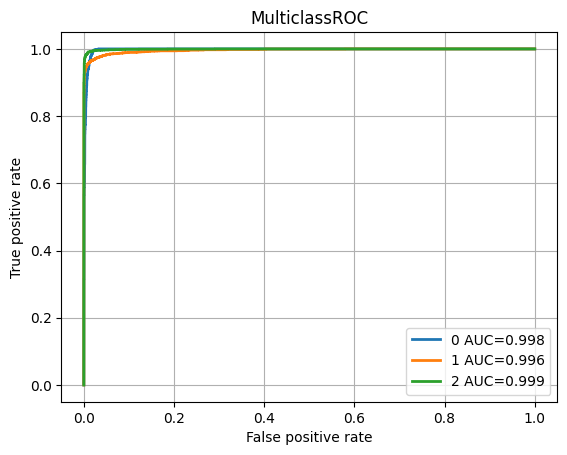

In [10]:
from torchmetrics import AUROC

# Flatten the true labels and predicted probabilities
flat_y_true = y_true.reshape(-1)
flat_y_pred_probs = y_pred_probs.reshape(-1, y_pred_probs.shape[-1])

auroc = AUROC(task="multiclass", num_classes=3)
auroc_val = auroc(torch.from_numpy(flat_y_pred_probs), torch.from_numpy(flat_y_true))
print(f"AUROC: {auroc_val.item()}")
#roc curve multiclass torchmetrics
from torchmetrics import ROC 

roc = ROC(num_classes=3 , task="multiclass")
fpr, tpr, thresholds = roc(torch.from_numpy(flat_y_pred_probs), torch.from_numpy(flat_y_true))
fig_, ax_ = roc.plot(score=True)

In [12]:
#AUC Score of each class
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

auc_ = []
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc_x = auc(fpr, tpr)
    print(f'Class {i} AUC: {roc_auc_x:.6f}')
    auc_.append(roc_auc_x)
    roc_auc[i] = (roc_auc_x)

print(f'Mean AUC: {np.mean(auc_):.4f}')

Class 0 AUC: 0.997666
Class 1 AUC: 0.996249
Class 2 AUC: 0.999305
Mean AUC: 0.9977
